# **Python script to classify 5 different classes of Cardiac disorders using latent space embeddings of Recurrence plots**

### Input : path to the Recurrence Plots.

### Output : Classification using latent space embeddings by CNN model.

In [188]:
#Importing necessary libraries

import numpy as np 
import pandas as pd
import os
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE
import math
from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchinfo import summary
from torchmetrics.image import StructuralSimilarityIndexMeasure



# Hyperparameters/ Config
### Fine tune the hyperparameters based on your problem statement

In [189]:
PRETRAINED = True
ROIS=15
SEED = 6
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.20
OPTIMIZER = 'Adam'
DATASET_PATH = "path to Recurrence plots folder" 
PRETRAINED_MODEL_PATH = 'path to embedding_autoencoder.pt'
NUM_EPOCHS = 1000
EMBEDDING_CHANNELS = 1

### Function To compare the orginal image with the reconstructed image

In [190]:
def show(data1, data2):
    '''function to visually compare the reconstructed image with the input images
    Each subject is represented by 2 rows and each pair of column corresponds to a ROI
    We can centre Crop the images before feeding to the Autoencoder (Custom Dataset)to get rid of the yellow border ,,
    '''

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for i in range(0, 2):
        for j in range(0, 10, 2):
            ax1 = axes[i][j]
            channel1 = data1[i * 5 + j]
            ax1.imshow(channel1, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax1.axis('off')
            ax1.set_title('original')

            ax2 = axes[i][j + 1]
            channel2 = data2[i * 5 + (j // 2)]
            ax2.imshow(channel2, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax2.axis('off')
            ax2.set_title('reconstructed')

    plt.show()

### To merge all 15 channels into $15\times 224\times224$ tensor

In [191]:
class AutoEncoderDataset(Dataset):
    '''
    input: path to all the recurrence plots
    ouput: a mutli-channel tensor with channels corresponding to ROIs of a brain network
    Dataset class AutoEncoderDataset get's the resized recurrence and stacks the singel channel image to make the input as a multichannel image
    ROIi corresponds to ith channel in all datapoints
    '''
    def __init__(self, root_dir, in_num_channels, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.labels = []
        self.samples = []
        rois =["i","ii","iii","avr","avl","avf","v1","v2","v3","v4","v5","v6","vx","vy","vz"]
        for class_name in ['Healthy control', 'Myocardial infarction','Bundle branch block','Cardiomyopathy','Dysrhythmia']:
            class_dir = os.path.join(root_dir, class_name)


            for file_name in os.listdir(class_dir):
                if file_name.endswith("vz.png"):
                    paths = [os.path.join(class_dir, file_name.replace("vz.png", f"{rois[i]}.png")) for i in range(0,in_num_channels)]
                    if all(os.path.exists(path) for path in paths):
                        label = os.path.join(class_dir, file_name)
                        new_label = (label.split('/')[-2],label.split('/')[-1][:8])
                        self.samples.append((paths, new_label))
                        self.labels.append(new_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        images = []

        for path in paths:
            image = Image.open(path)
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.CenterCrop((225,224)),
                transforms.Lambda(lambda img: img.crop((0, 0, img.width, img.height - 1))),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
            image_tensor = transform(image)
            images.append(image_tensor)

        combined_image = torch.stack(images, dim=1).squeeze()

        if self.transform:
            image = self.transform(combined_image)
        else:
            image = combined_image
        return image, label

### CNN based AUTOENCODER MODEL

In [192]:
class Autoencoder(nn.Module):
    '''autoencoder architecture'''
    def __init__(self, rois, emb_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # rois x 224 x 224
            nn.Conv2d(rois, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            # 64 x 112 x 112
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            # 128 x 56 x 56
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            # 256 x 28 x 28
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            # 512 x 28 x 28
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(1024, emb_channels, kernel_size=3, padding=1),
            nn.ReLU(),
#             nn.BatchNorm2d(emb_channels),
            nn.Dropout(0.25),
        )

        self.decoder = nn.Sequential(
            # 1024 x 14 x 14
            nn.ConvTranspose2d(emb_channels, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # 512 x 28 x 28
            nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # 256 x 28 x 28
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # 128 x 56 x 56
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # 64 x 112 x 112
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, rois, kernel_size=3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        x = self.encoder(x)
        bottleneck_output = self.bottleneck(x)
        x = self.decoder(bottleneck_output)
        return x, bottleneck_output

### AUTOENCODER MODEL Summary

In [193]:
autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
summary(autoencoder_model, input_size=(BATCH_SIZE,ROIS,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [16, 15, 224, 224]        --
├─Sequential: 1-1                        [16, 1024, 14, 14]        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        8,704
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 224, 224]        128
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─ReLU: 2-5                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-6                  [16, 64, 224, 224]        128
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─ReLU: 2-9                         [16, 128, 112, 112]       --
│    └─BatchNorm2d: 2-10                 [16, 128, 112, 112]       256
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,

### * Training and testing dateset creation
### * Autoencoder model training

In [194]:
torch.manual_seed(SEED)

#%%%%%%%%%%%%%%%%%%%%%%%     DATASET CREATION   %%%%%%%%%%%%%%%%%%%%%%%
custom_dataset = AutoEncoderDataset(root_dir=DATASET_PATH, in_num_channels=ROIS)
data_dl = DataLoader(custom_dataset, batch_size=BATCH_SIZE)
test_size = int(len(custom_dataset) * TRAIN_TEST_SPLIT)
train_size = len(custom_dataset) - test_size
train_ds, test_ds = random_split(custom_dataset, [train_size, test_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE) # set aside test data in the initial part

if PRETRAINED :
    #%%%%%%%%%%%%%%%%%%%%%%%     PRE TRAINED MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    # device = torch.device("cuda" if torch.cuda.is_built() else "cpu") # on windows/ linux
    device = 'cuda' # on macOS
    autoencoder_model = autoencoder_model.to(device)
    state_dict = torch.load(PRETRAINED_MODEL_PATH)
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = value

    autoencoder_model.load_state_dict(new_state_dict)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    criterion_mle = nn.MSELoss()
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9) # change the hyperparamertes if you are using SGD
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
else :
    # #%%%%%%%%%%%%%%%%%%%%%%%     MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    criterion_mle = nn.MSELoss()
    autoencoder_model = autoencoder_model.to(device)
    autoencoder_model = DataParallel(autoencoder_model)
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
    #%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        autoencoder_model.train()
        train_loss = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = autoencoder_model(inputs)
            loss_ssim = 1- criterion(outputs[0], inputs)
            loss_mle = criterion_mle(outputs[0],inputs)
            loss = loss_mle+loss_ssim
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            criterion.update(outputs[0],inputs)

        autoencoder_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_dl:
                inputs = inputs.to(device)
                outputs = autoencoder_model(inputs)
                loss_ssim = 1-criterion(outputs[0], inputs)
                loss_mle = criterion_mle(outputs[0],inputs)
                loss = loss_mle+loss_ssim
                val_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.5f} Val Loss: {val_loss:.5f}")
        
    torch.save(autoencoder_model.state_dict(), f'autoencoder.pt')

### Comparing orginal image to reconstructed ones

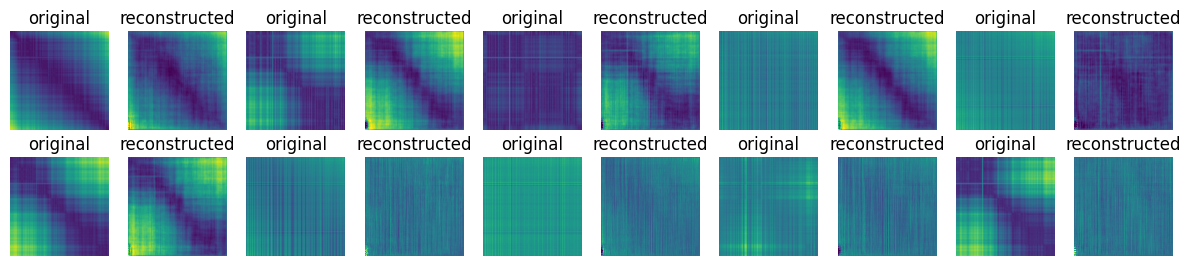

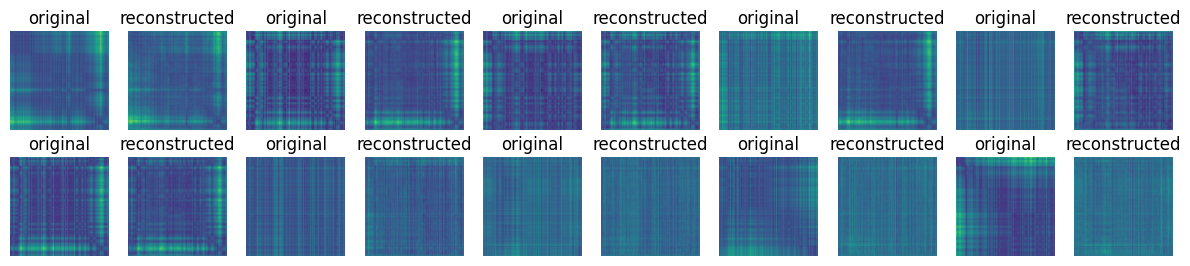

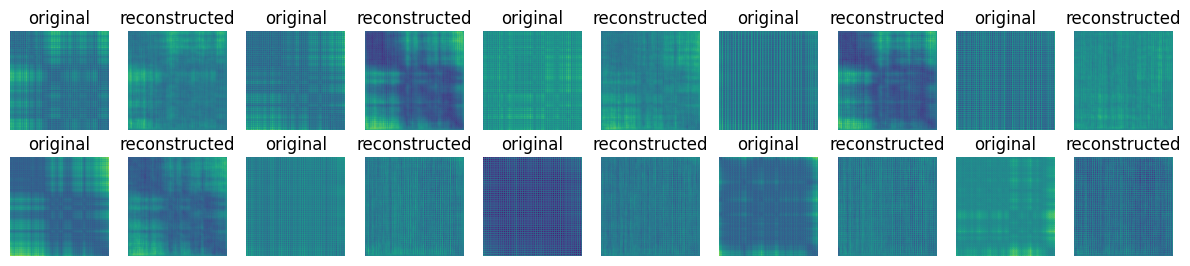

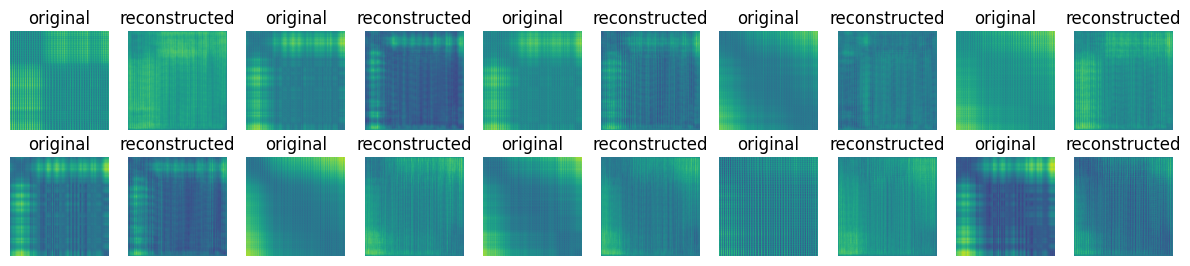

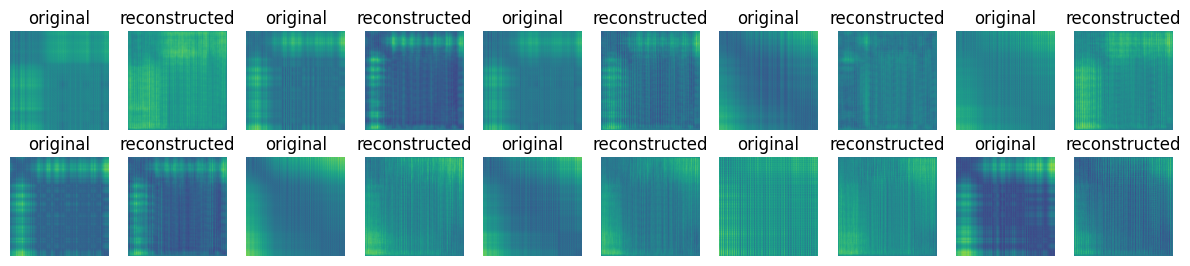

In [195]:
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        outputs = autoencoder_model(inputs)
        for k in range(5):
            show(inputs[k].to('cpu').numpy(), outputs[0][k].to('cpu').numpy())
        break

### Latent Space embeddings of whole dataset

In [196]:
embedded_dataset = {'Myocardial infarction':{}, 'Healthy control':{},'Bundle branch block':{},'Cardiomyopathy':{},'Dysrhythmia':{}}
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in data_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            embedded_dataset[class_][subj] = embedding[k].cpu().numpy()

### Latent Space embeddings of Training dataset

In [197]:
embedded_data = {'Myocardial infarction':{}, 'Healthy control':{},'Bundle branch block':{},'Cardiomyopathy':{},'Dysrhythmia':{}}
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            embedded_data[class_][subj] = embedding[k].cpu().numpy()

### Latent Space embeddings of Test dataset

In [198]:
embedded_data_test = {'Myocardial infarction':{},'Healthy control':{},'Bundle branch block':{},'Cardiomyopathy':{},'Dysrhythmia':{}}
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            embedded_data_test[class_][subj] = embedding[k].cpu().numpy()


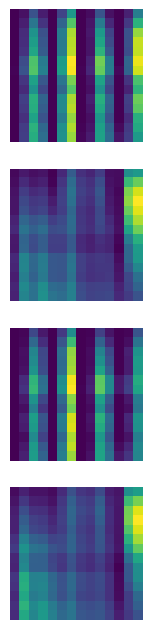

In [199]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Myocardial infarction'].keys())[i]
        plt.imshow(embedded_data['Myocardial infarction'][subj][channel])
        plt.axis('off')
plt.show()

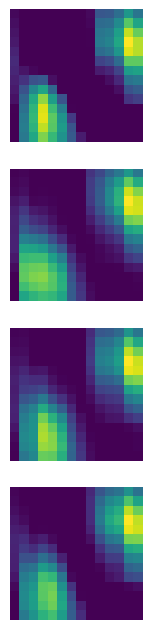

In [200]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Bundle branch block'].keys())[i]
        plt.imshow(embedded_data['Bundle branch block'][subj][channel])
        plt.axis('off')
plt.show()

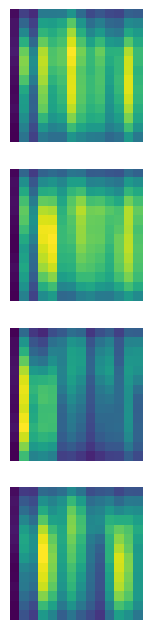

In [201]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Cardiomyopathy'].keys())[i]
        plt.imshow(embedded_data['Cardiomyopathy'][subj][channel])
        plt.axis('off')
plt.show()

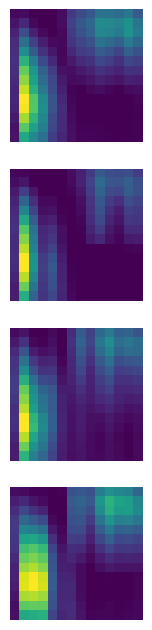

In [202]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Dysrhythmia'].keys())[i]
        plt.imshow(embedded_data['Dysrhythmia'][subj][channel])
        plt.axis('off')
plt.show()

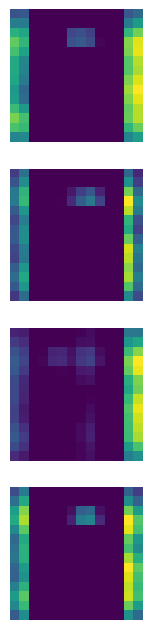

In [203]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Healthy control'].keys())[i]
        plt.imshow(embedded_data['Healthy control'][subj][channel])
        plt.axis('off')
plt.show()

### Dataset creation for CNN classifer

In [204]:
class EmbeddedDataset(Dataset):
    '''Dataset class for classifying the latent space representation
    '''
    def __init__(self, class1_dict, class2_dict, class3_dict, class4_dict, class5_dict):
        self.class1_data = list(class1_dict.values())
        self.class2_data = list(class2_dict.values())
        self.class3_data = list(class3_dict.values())
        self.class4_data = list(class4_dict.values())
        self.class5_data = list(class5_dict.values())
        
        self.class1_labels = [0] * len(self.class1_data)
        self.class2_labels = [1] * len(self.class2_data)
        self.class3_labels = [2] * len(self.class3_data)
        self.class4_labels = [3] * len(self.class4_data)
        self.class5_labels = [4] * len(self.class5_data)
        
        self.data = self.class1_data + self.class2_data + self.class3_data + self.class4_data + self.class5_data
        self.labels = self.class1_labels + self.class2_labels + self.class3_labels + self.class4_labels + self.class5_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = torch.Tensor(self.data[index])
        label = self.labels[index]
        return data, label

emb_data = EmbeddedDataset(embedded_data['Healthy control'], embedded_data['Myocardial infarction'], embedded_data['Bundle branch block'], embedded_data['Cardiomyopathy'], embedded_data['Dysrhythmia'])
val_size = int(len(emb_data) * 0.15)
train_size = len(emb_data) - val_size
train_ds, val_ds = random_split(emb_data, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)
emb_data_test = EmbeddedDataset(embedded_data_test['Healthy control'], embedded_data_test['Myocardial infarction'],embedded_data_test['Bundle branch block'],embedded_data_test['Cardiomyopathy'],embedded_data_test['Dysrhythmia'])
test_dl = DataLoader(emb_data_test, batch_size=8)
emb_dataset = EmbeddedDataset(embedded_dataset['Healthy control'],embedded_dataset['Myocardial infarction'],embedded_dataset['Bundle branch block'],embedded_dataset['Cardiomyopathy'],embedded_dataset['Dysrhythmia'])
dataset_dl = DataLoader(emb_dataset, batch_size=8)


### Simple CNN Classifier Model

In [205]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            # input 1 x 14 x 14
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # Two output classes for binary classification
        )

    def forward(self, x):
        return self.model(x)
    

### Classifier model training

In [206]:
classfier_model = SimpleCNN(EMBEDDING_CHANNELS)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = classfier_model.to(device)
model = DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer_type = 'Adam'
learning_rate = 5e-5

if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

#%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
train_losses = []
val_losses = []
train_accu = []
val_accu = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loss += loss.item()
    train_accuracy = 100 * train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # Accumulate validation loss

            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_dl)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accu.append(train_accuracy)
    val_accu.append(val_accuracy)
    


    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    

Epoch [1/10]: Train Loss: 20.0513, Train Accuracy: 48.28%, Val Loss: 0.9907, Val Accuracy: 50.00%
Epoch [2/10]: Train Loss: 11.6559, Train Accuracy: 66.38%, Val Loss: 0.5281, Val Accuracy: 90.00%
Epoch [3/10]: Train Loss: 5.2384, Train Accuracy: 93.97%, Val Loss: 0.1724, Val Accuracy: 100.00%
Epoch [4/10]: Train Loss: 1.5279, Train Accuracy: 100.00%, Val Loss: 0.0418, Val Accuracy: 100.00%
Epoch [5/10]: Train Loss: 0.4309, Train Accuracy: 100.00%, Val Loss: 0.0130, Val Accuracy: 100.00%
Epoch [6/10]: Train Loss: 0.1829, Train Accuracy: 100.00%, Val Loss: 0.0073, Val Accuracy: 100.00%
Epoch [7/10]: Train Loss: 0.0911, Train Accuracy: 100.00%, Val Loss: 0.0044, Val Accuracy: 100.00%
Epoch [8/10]: Train Loss: 0.0540, Train Accuracy: 100.00%, Val Loss: 0.0034, Val Accuracy: 100.00%
Epoch [9/10]: Train Loss: 0.0374, Train Accuracy: 100.00%, Val Loss: 0.0029, Val Accuracy: 100.00%
Epoch [10/10]: Train Loss: 0.0285, Train Accuracy: 100.00%, Val Loss: 0.0025, Val Accuracy: 100.00%


$\Large Training \:Loss\: Curve$

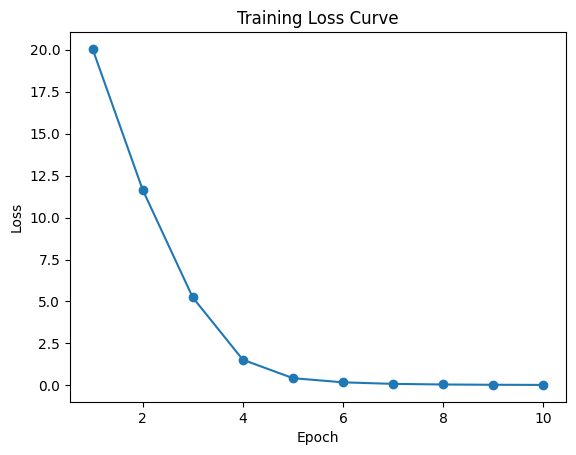

In [207]:
epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Validation Loss Curve

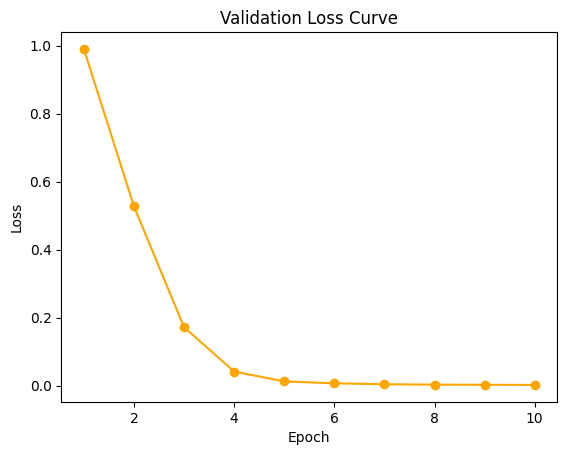

In [208]:
plt.plot(epochs, val_losses, marker='o', color = 'orange')
plt.title('Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Training and Validation losses Curve

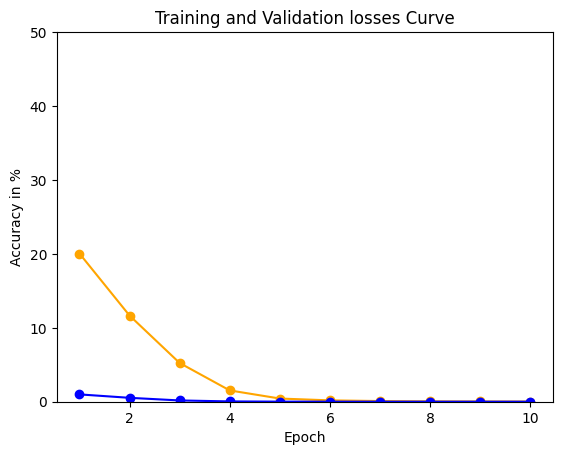

In [209]:
plt.plot(epochs,train_losses,marker='o',color = 'orange')
plt.plot(epochs,val_losses,marker='o',color = 'blue')
plt.title('Training and Validation losses Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy in %')
plt.ylim(0,50)
plt.show()

### Training and Validation Accuracy Curve

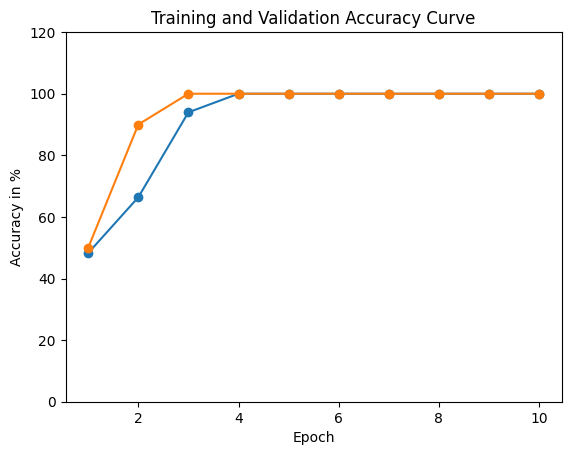

In [210]:
plt.plot(epochs, train_accu, marker='o')
plt.plot(epochs, val_accu, marker='o')
plt.title('Training and Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy in %')
plt.ylim(0,120)
plt.show()

* $\Large Confusion \; Matrix $
* $\Large Classification \; Report$

Test Accuracy:  1.0


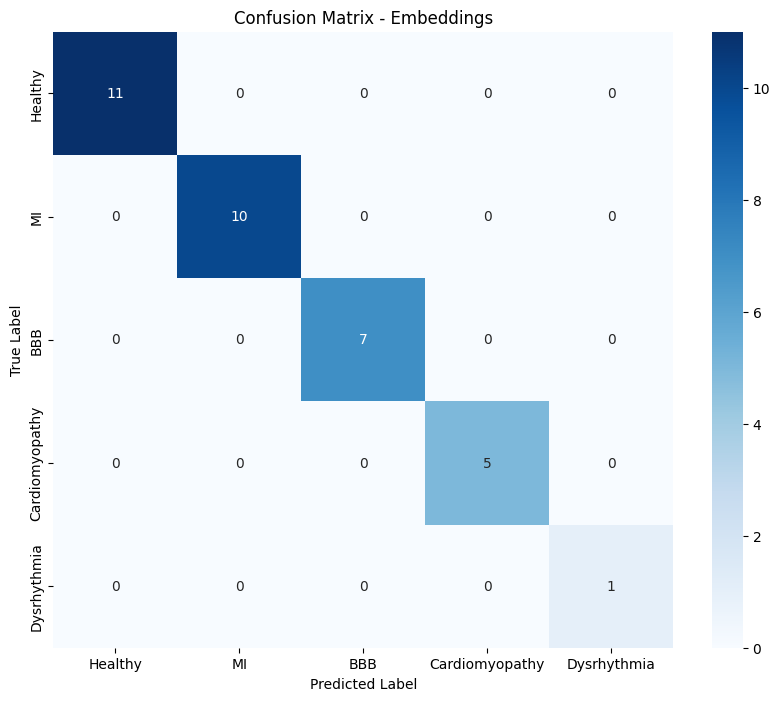

                precision    recall  f1-score   support

       Healthy       1.00      1.00      1.00        11
            MI       1.00      1.00      1.00        10
           BBB       1.00      1.00      1.00         7
Cardiomyopathy       1.00      1.00      1.00         5
   Dysrhythmia       1.00      1.00      1.00         1

      accuracy                           1.00        34
     macro avg       1.00      1.00      1.00        34
  weighted avg       1.00      1.00      1.00        34



In [211]:
num_classes = 5
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Convert to int (0 or 1)
        conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=[0, 1, 2, 3,4])
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        
        
print("Test Accuracy: ", accuracy_score(labels.cpu(), predicted.cpu()))      
        
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia'], yticklabels=['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Embeddings")
plt.savefig('Confusion Matrix - Embeddings .png', dpi=300)
plt.show()

# Classification Report
target_names = ['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia']
print(classification_report(all_labels, all_predictions, labels=[0, 1, 2, 3,4],target_names=target_names))


###  t-SNE Plot

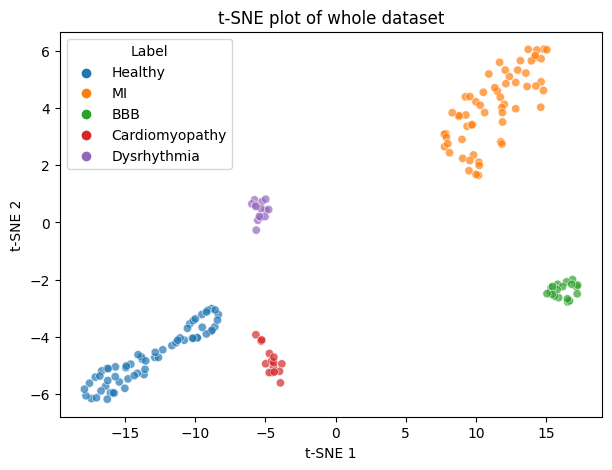

In [212]:
disease_names = ['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia']
def map_labels_to_disease_names(labels):
    '''This Function returns the disease names form its corresponding numeric label '''
    return [disease_names[label] for label in labels]
    
custom_palette = {
    'Healthy': '#1f77b4',  # Blue
    'MI': '#ff7f0e',      # Orange
    'BBB': '#2ca02c',     # Green
    'Cardiomyopathy': '#d62728',  # Red
    'Dysrhythmia': '#9467bd'      # Purple
}
def T_SNE_plot(data,title):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            outputs = model(inputs)
            all_features.append(outputs.cpu())
            all_labels.append(labels.cpu())
            
        
        
    # Concatenate all features and labels
    all_features = torch.cat(all_features).numpy()
    all_labels = torch.cat(all_labels).numpy()

   
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(all_features)
    label_names = map_labels_to_disease_names(all_labels)
    df = pd.DataFrame({'Dimension 1': tsne_results[:, 0], 'Dimension 2': tsne_results[:, 1], 'Label': label_names})
    # Plot the results
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2', hue='Label', palette = custom_palette, alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.savefig(f'{title}.png', dpi=300)
    plt.show()
    

T_SNE_plot(dataset_dl,"t-SNE plot of whole dataset")
